In [1]:
%matplotlib inline
import numpy as np
import pandas as pd
from pathlib import Path
import os, sys, datetime, time, random, fnmatch
import matplotlib.pyplot as plt
import matplotlib.animation as animation
import skimage.metrics

import torch
from torchvision import transforms as tvtransforms
from torch.utils.data import Dataset, DataLoader
import torchvision.utils as vutils
import torch.utils.tensorboard as tensorboard
import torch.nn as nn

# Own functions
from dataloaders import Dataset_CTCovid19August2020, Dataset_PolyU_CXR
import transforms
import blocks
import pytorch_msssim

# Flags:
flag_debug = False
flag_retrain_intermediate_network = False

# Input directories
#DRR_directory = "D:\data\CT-Covid-19-August2020\DRR_output"
#CXR_directory = "D:\data\POLYU_COVID19_CXR_CT_Cohort1"
DRR_directory = "G:\DanielLam\CT-Covid-19-August2020\DRR_output"
CXR_directory = "G:\DanielLam\POLYU_COVID19_CXR_CT_Cohort1"

# Save directories
output_save_directory = Path("./runs/ResUNetPixelShuffle_G_PatchGAN_D_v1/")
output_save_directory.mkdir(parents=True, exist_ok=True)
PATH_G = os.path.join(output_save_directory, "netG.pt") # path to save weights for generator
PATH_D = os.path.join(output_save_directory, "netD.pt") # path to save weights for discriminator
PATH_G_int1 = os.path.join(output_save_directory, "netG_int1.pt")

# Pre-training
num_epochs_generator_pretraining = 100

# Settings for training:
num_epochs_generator = 20 # Isola et al. Image-to-Image Translation with CGANs
_batch_size = 3 # 1 per GPU at least
discriminator_keys_images = ["source", "boneless", "lung"]
generator_keys_images = ["source"]
generator_target = "boneless"
image_spatial_size = (512,512)

# Adam Optimiser
# Pretraining
lr_pretraining = 0.001 # Gusarev
beta1_pretraining = 0.9
beta2_pretraining = 0.999

# Parameters from: Isola et al. 2016 Image-to-Image Translation
lr = 0.0002
beta1=0.5
beta2=0.999
"""
# Parameters from: Diakogiannis et al. ResUNet-A paper
lr = 0.001
beta1 = 0.9
beta2 = 0.999
"""
# Techniques for improved training
# Label Smoothing
random.seed(0)
flip_rate_threshold = 0.05 # for this, 0.25 means 25% of the time, real and fake labels are flipped.

# Decide which device we want to run on
ngpu = 3
device = torch.device("cuda" if (torch.cuda.is_available() and ngpu > 0) else "cpu")
os.environ["CUDA_VISIBLE_DEVICES"] = "0, 1, 2"
print(device)
# Current date:
current_date=datetime.datetime.today().strftime('%Y-%m-%d')

cuda


In [2]:
# Set up datasets and dataloaders
ds_discriminator = Dataset_CTCovid19August2020(os.path.join(DRR_directory,"DRR_directory.csv"), 
                                               os.path.join(DRR_directory), 
                                 transform=tvtransforms.Compose([
                                     transforms.Rescale(image_spatial_size, discriminator_keys_images, "PixelSize"),
                                     transforms.RescalingNormalisation(discriminator_keys_images),
                                     transforms.Random180(discriminator_keys_images, probability=0.5),
                                     transforms.IntensityJitter(discriminator_keys_images,rescale_factor_limits=(0.5,1.0)),
                                     transforms.RandomIntensityFlip(discriminator_keys_images, probability=0.5),
                                     transforms.ToTensor(discriminator_keys_images),
                                     ]))

ds_generator = Dataset_PolyU_CXR(Path(CXR_directory),
                                 transform=tvtransforms.Compose([
                                     transforms.Rescale(image_spatial_size, generator_keys_images, "PixelSize"),
                                     transforms.ImageComplement(generator_keys_images),
                                     transforms.RescalingNormalisation(generator_keys_images),
                                     transforms.ToTensor(generator_keys_images),
                                     ]))

dl_training = DataLoader(ds_discriminator, batch_size=_batch_size,
                        shuffle=True, num_workers=0)
dl_testing = DataLoader(ds_generator, batch_size=_batch_size,
                        shuffle=True, num_workers=0)

tensor(0.0582)


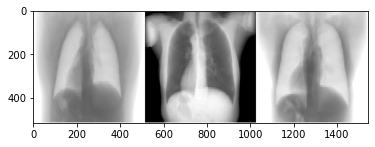

In [3]:
def matplotlib_imshow(img, one_channel=False):
    if one_channel:
        img = img.mean(dim=0)
    npimg = img.numpy()
    if one_channel:
        plt.imshow(npimg, cmap="Greys")
    else:
        plt.imshow(np.transpose(npimg, (1, 2, 0)))
# get some random training images
dataiter = iter(dl_training)
sample = dataiter.next()
# create grid of images
img_grid = vutils.make_grid(sample[generator_target])
# show images
matplotlib_imshow(img_grid, one_channel=True)

msssim = pytorch_msssim.MSSSIM(window_size=11, size_average=True, channel=1)
msssim_loss = 1 - msssim(sample["boneless"], sample["source"])
print(msssim_loss)

In [4]:
# Implementation of Network
def weights_init(m):
    # From DCGAN paper
    classname = m.__class__.__name__
    if isinstance(m, nn.Conv2d) or isinstance(m, nn.ConvTranspose2d):
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    if isinstance(m, nn.BatchNorm2d):
        if m.affine:
            nn.init.normal_(m.weight.data, 1.0, 0.02)
            nn.init.constant_(m.bias.data, 0)
    
    """for i in m.children():
        # Specific weight setting for ResUNet shortcut.
        if i.__class__.__name__ == "ResUNet_shortcut":
            for ii in i.children():
                if isinstance(ii, nn.Conv2d) or isinstance(ii, nn.ConvTranspose2d):
                    nn.init.constant_(ii.weight.data, 1.)
            for param in i.parameters():
                param.requires_grad=False"""


# Network Structure
_initial_channels_out = 32 # Diakogiannis et al. ResUNet-A: A deep learning framework for semantic segmentation of remotely-sensed data
_input_array_shape_classifier = (_batch_size, 2 , image_spatial_size[0], image_spatial_size[1])  # 2 channels -- channel 0 for source, channel 1 for real/fake boneless
_input_array_shape_generator = (_batch_size, 1 , image_spatial_size[0], image_spatial_size[1])


netG = blocks.Generator_ResUNet_modified(_input_array_shape_generator, _first_out_channels=64,
                                _reluType="leaky", _dropoutType="ADL", _drop_rate=0.75)
"""
netG = blocks.Generator_Pix2Pix(_input_array_shape_generator, 
                                _normType="BatchNorm", _dropoutType = "ADL", _dropRate=0.5)

netG = blocks.Generator_ResUNet_A(_input_channels=_initial_channels_out, _input_array_shape=_input_array_shape_generator,
                                  _norm_type='BatchNorm', _ADL_drop_rate=0.75, _ADL_gamma=0.9)

netD = blocks.MultiScale_Classifier(_input_channels=_initial_channels_out, _input_array_shape=_input_array_shape_classifier,
                                    _classifier_out_channels=64,
                                    _norm_type='BatchNorm', _ADL_drop_rate=0.75, _ADL_gamma=0.9)
"""
netD = blocks.Discriminator_Pix2Pix(_input_array_size = _input_array_shape_classifier)

# Initialise weights
netG.apply(weights_init)
netD.apply(weights_init)

# Multi-GPU
if (device.type == 'cuda') and (ngpu > 1):
    netG = nn.DataParallel(netG, list(range(ngpu)))
    netD = nn.DataParallel(netD, list(range(ngpu)))

netG = netG.to(device)
netD = netD.to(device)

# Fixed Test Sample
dl_test = DataLoader(ds_generator, batch_size=_batch_size,
                        shuffle=False, num_workers=0)
fixed_test_image = next(iter(dl_test))

In [ ]:
# Training loop for Generator first
import pytorch_msssim
if flag_retrain_intermediate_network or not(os.path.isfile(PATH_G_int1)):
    # Optimiser
    optimizerG = torch.optim.Adam(netG.parameters(), lr=lr_pretraining, betas=(beta1_pretraining, beta2_pretraining))
    
    # Loss
    def criterion_Gusarev(testImage, referenceImage, alpha=0.84):
        mseloss = nn.MSELoss() # L2 used for easier optimisation
        
        msssim = pytorch_msssim.MSSSIM(window_size=11, size_average=True, channel=1)
        msssim_loss = 1 - msssim(testImage, referenceImage)
        
        total_loss = (1-alpha)*mseloss(testImage, referenceImage) + alpha*msssim_loss
        return total_loss
    
    # Data Input
    img_list_pretraining = []
    iters=0
    print("Beginning Training...")
    for epoch in range(num_epochs_generator_pretraining):
        # For each batch in the dataloader
        for i, data in enumerate(dl_training):
            # Save a training image
            if iters == 0:
                fixed_training_image = data['source']
            ##############################
            # Match NetG output to the ground-truth
            ##############################
            netG.zero_grad()
            noisy_data = data['source'].to(device)
            fake = netG(noisy_data)
            loss = criterion_Gusarev(fake, data[generator_target].to(device))
            loss.backward() # calculate gradients
            optimizerG.step() # optimiser step along gradients
            
            # Output training stats
            if i % 50 == 0:
                print('[%d/%d][%d/%d]\tLoss_G: %.4f'
                      % (epoch, num_epochs_generator_pretraining, i, len(dl_training),
                         loss.item()))
            # Record generator output
            if (iters % 100 == 0) or ((epoch == num_epochs_generator_pretraining-1) and (i == len(dl_training)-1)):
                with torch.no_grad():
                    fake = netG(fixed_training_image).detach().cpu()
                img_list_pretraining.append(vutils.make_grid(fake, padding=2, normalize=True))
            iters += 1

    torch.save(netG.state_dict(), PATH_G_int1)
    
if not(flag_retrain_intermediate_network) and os.path.isfile(PATH_G_int1):
    # If not retraining, load the network into netG
    print("Loading Saved Pre-trained State")
    netG.load_state_dict(torch.load(PATH_G_int1))
    

Beginning Training...


C:\Users\Y1112\anaconda3\envs\daniel\lib\site-packages\torch\cuda\nccl.py:16: UserWarning: PyTorch is not compiled with NCCL support
  warnings.warn('PyTorch is not compiled with NCCL support')


[0/100][0/217]	Loss_G: 0.4300
[0/100][50/217]	Loss_G: 0.0637
[0/100][100/217]	Loss_G: 0.0595
[0/100][150/217]	Loss_G: 0.0589
[0/100][200/217]	Loss_G: 0.0536
[1/100][0/217]	Loss_G: 0.0465
[1/100][50/217]	Loss_G: 0.0396
[1/100][100/217]	Loss_G: 0.0577
[1/100][150/217]	Loss_G: 0.0626
[1/100][200/217]	Loss_G: 0.0592
[2/100][0/217]	Loss_G: 0.0629
[2/100][50/217]	Loss_G: 0.0583
[2/100][100/217]	Loss_G: 0.0430
[2/100][150/217]	Loss_G: 0.0712
[2/100][200/217]	Loss_G: 0.0635
[3/100][0/217]	Loss_G: 0.0581
[3/100][50/217]	Loss_G: 0.0522
[3/100][100/217]	Loss_G: 0.0544
[3/100][150/217]	Loss_G: 0.0511
[3/100][200/217]	Loss_G: 0.0551
[4/100][0/217]	Loss_G: 0.0447
[4/100][50/217]	Loss_G: 0.0472
[4/100][100/217]	Loss_G: 0.0636
[4/100][150/217]	Loss_G: 0.0362
[4/100][200/217]	Loss_G: 0.0507
[5/100][0/217]	Loss_G: 0.0290
[5/100][50/217]	Loss_G: 0.0425
[5/100][100/217]	Loss_G: 0.0525
[5/100][150/217]	Loss_G: 0.0494
[5/100][200/217]	Loss_G: 0.0514
[6/100][0/217]	Loss_G: 0.0373
[6/100][50/217]	Loss_G: 0.03

In [ ]:
# INFERENCE OUTPUTS

# Fixed Test Sample
fixed_test_image = next(iter(dl_testing))
fixed_training_image = next(iter(dl_training))

with torch.no_grad():
    input_image = fixed_test_image['source'] #fixed_test_image['source']
    input_images = vutils.make_grid(input_image, padding=2, normalize=True)
    output_image = netG(input_image).detach().cpu()
    output_images = vutils.make_grid(output_image, padding=2, normalize=True)

print(str(torch.max(input_images)) + "," + str(torch.min(input_images)))

fig, ax = plt.subplots(2,1)
ax[0].imshow(np.transpose(input_images, (1,2,0)))
ax[0].set_title("Source")
ax[1].imshow(np.transpose(output_images, (1,2,0)))
ax[1].set_title("Suppressed")
plt.show
if not flag_debug:
    fig.savefig(os.path.join(output_save_directory, current_date + "pretraining"+".png"))

In [ ]:
## Training Loop for GAN

# Helper Functions
def set_requires_grad(nets, requires_grad=False):
    """https://github.com/junyanz/pytorch-CycleGAN-and-pix2pix/blob/f13aab8148bd5f15b9eb47b690496df8dadbab0c/models/base_model.py#L219
    Set requires_grad=Fasle for all the networks to avoid unnecessary computations
    Parameters:
        nets (network list)   -- a list of networks
        requires_grad (bool)  -- whether the networks require gradients or not
    """
    if not isinstance(nets, list):
        nets = [nets]
    for net in nets:
        if net is not None:
            for param in net.parameters():
                param.requires_grad = requires_grad
    return net

# Loss Functions
# IF USING BCEWithLogitsLoss, do NOT use Sigmoid as output activation for Discriminator
def criterion_Pix2Pix(input_image, ground_truth_image, input_label, ground_truth_label, reg_lambda=100):
    L_cGAN = nn.BCEWithLogitsLoss(reduction="mean")
    L_l1 = nn.L1Loss(reduction="mean")
    out = L_cGAN(input_label , ground_truth_label) + reg_lambda*L_l1(input_image , ground_truth_image)
    return out
def criterion_BCE(input_label, ground_truth_label):
    L_cGAN = nn.BCEWithLogitsLoss(reduction="mean")
    out = L_cGAN(input_label, ground_truth_label)
    return out

# Setup Adam optimizers for both G and D
optimizerD = torch.optim.Adam(netD.parameters(), lr=lr, betas=(beta1, beta2))
optimizerG = torch.optim.Adam(netG.parameters(), lr=lr, betas=(beta1, beta2))

# Lists to keep track of progress
img_list = []
G_losses = []
D_losses = []
D_G_z1_list = []
D_G_z2_list = []
D_x_list = []
iters = 0

print("Beginning Training...")
# For each epoch
torch.autograd.set_detect_anomaly(True)
for epoch in range(num_epochs_generator):
    # For each batch in the dataloader
    for i, data in enumerate(dl_training):
        
        ############################
        # Labels
        ############################
        # Label Smoothing as mentioned by Salimans et al. 2016 Improved Techniques for Training GANs
        real_label = random.uniform(0.7,1.0) 
        fake_label = random.uniform(0.0,0.3)
        
        # Label flipping to cripple discriminator
        flip_probability = random.uniform(0.,1.)
        fake_label_original = fake_label
        real_label_original = real_label
        if flip_probability < flip_rate_threshold:
            fake_label = real_label_original
            real_label = fake_label_original
        
        fake_label = torch.tensor(fake_label)
        real_label = torch.tensor(real_label)
        ###########################
        # (0) Generate fake image batch with G
        ###########################
        conditioning_data = data['source'].to(device)
        fake = netG(conditioning_data)    

        ############################
        # (1) Update D network: maximize log(D(x)) + log(1 - D(G(z)))
        ###########################
        
        ## Train with all-real batch
        netD = set_requires_grad(netD, True)
        optimizerD.zero_grad()
        
        ## REAL DATA
        real_data = torch.cat((data['source'].to(device), data[generator_target].to(device)), dim=1)
        # Forward pass real batch through D and flatten
        pred_real = netD(real_data)
        label_real = real_label.expand_as(pred_real)
        # Calculate loss on all-real batch
        errD_real = criterion_BCE(pred_real, label_real)
        
        
        ## FAKE DATA
        fake_data = torch.cat((data['source'].to(device) , fake), dim=1)
        # Fake is detached because the .backwards() command destroys parts of the computational graph
        pred_fake = netD(fake_data.detach())
        label_fake = fake_label.expand_as(pred_fake)
        # Calculate loss on the all-fake batch
        errD_fake = criterion_BCE(pred_fake, label_fake)
        
        # Calculate the gradients for this batch together
        errD = (errD_fake + errD_real)*0.5
        errD.backward()
        
        # Update D
        optimizerD.step()
        
        D_x = pred_real.mean().item()
        D_G_z1 = pred_fake.mean().item() 
        
        
        ############################
        # (2) Update G network: maximize log(D(G(z)))
        ###########################
        netD = set_requires_grad(netD, False)
        optimizerG.zero_grad()
        real_label = torch.tensor(real_label_original) # only flip for discriminator
        
        # Since we just updated D, perform another forward pass of all-fake batch through D
        # fake CANNOT be detached here.
        fake_data = torch.cat((data['source'].to(device), fake), dim=1)
        pred_fake = netD(fake_data)
        label_real = real_label.expand_as(pred_fake)  # fake labels are real for generator cost
        # Calculate G's loss based on this output
        errG = criterion_Pix2Pix(fake.detach(), data[generator_target].detach(), pred_fake, label_real)
        # Calculate gradients for G and update optimizer
        errG.backward()
        optimizerG.step()
        
        D_G_z2 = pred_fake.mean().item()
        
        # Output training stats
        if i % 50 == 0:
            print('[%d/%d][%d/%d]\tLoss_D: %.4f\tLoss_G: %.4f\tD(x,z): %.4f\tD(G(z)): %.4f / %.4f'
                  % (epoch, num_epochs_generator, i, len(dl_training),
                     errD.item(), errG.item(), D_x, D_G_z1, D_G_z2))

        # Save Losses for plotting later
        G_losses.append(errG.item())
        D_losses.append(errD.item())
        D_G_z1_list.append(D_G_z1)
        D_G_z2_list.append(D_G_z2)
        D_x_list.append(D_x)
        
        # Check how the generator is doing by saving G's output on a fixed test image
        if (iters % 100 == 0) or ((epoch == num_epochs_generator-1) and (i == len(dl_training)-1)):
            with torch.no_grad():
                fake = netG(fixed_test_image['source']).detach().cpu()
            img_list.append(vutils.make_grid(fake, padding=2, normalize=True))

        iters += 1
        
        if flag_debug and i == 2:
            print(iters)
            print("DEBUGGING -- REMOVE THIS IF CONDITION IN FULL TEST")
            break
    if flag_debug and epoch == 2:
        print("DEBUGGING -- REMOVE THIS IF CONDITION IN FULL TEST")
        break



In [ ]:
# SAVE WEIGHTS
if not flag_debug:
    torch.save(netG.state_dict(), PATH_G)
    torch.save(netD.state_dict(), PATH_D)

# Plot G and D loss
plt.figure(figsize=(10,5))
plt.title("Generator and Discriminator Loss During Training")
plt.plot(G_losses,label="G")
plt.plot(D_losses,label="D")
plt.xlabel("iterations")
plt.ylabel("Loss")
plt.legend()
if not flag_debug:
    plt.savefig(os.path.join(output_save_directory, current_date + "training_loss"+".png"))
plt.show()
# Plot D errors
plt.figure(figsize=(10,5))
plt.title("Discriminator Error during Training")
plt.plot(D_G_z2_list,label="D Error for Generator Data")
plt.plot(D_x_list,label="D Error for Real Data")
plt.xlabel("iterations")
plt.ylabel("D Error")
plt.legend()
if not flag_debug:
    plt.savefig(os.path.join(output_save_directory, current_date + "D_errors"+".png"))
plt.show()

#%%capture
fig = plt.figure(figsize=(8,8))
plt.axis("off")
ims = [[plt.imshow(np.transpose(i,(1,2,0)), animated=True)] for i in img_list]
print(img_list[0].shape)
ani = animation.ArtistAnimation(fig, ims, interval=200, repeat_delay=1000, blit=True)
if not flag_debug:
    ani.save(os.path.join(output_save_directory, current_date+"generator_output.mp4"), dpi=300)

In [ ]:


"""# TENSORBOARD Visualisation
writer = tensorboard.SummaryWriter(Path('runs/MSAGAN_v1'))

# get some random training images
dataiter = iter(dl_training)
sample = dataiter.next()
print(sample['source'].shape)
# create grid of images
img_grid = vutils.make_grid(sample['source'])

# show images
matplotlib_imshow(img_grid, one_channel=True)

# write to tensorboard
writer.add_image('Images', img_grid)

writer.add_graph(netG, sample['source'])
writer.close()

%load_ext tensorboard
%tensorboard --logdir runs"""

In [ ]:
not(os.path.isfile(PATH_G_int1))